---
title: "Machine Learning Notes III: Linear Regression"
author: "Alejandro Pérez Sanjuán"
date: 2024-08-17
categories: [machine learning, python, linear regression]
format: html
---

Personal notes for myself about linear regression and how to implement it from scratch using least squares and gradient descent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.base import RegressorMixin

## 1. Introduction

Linear regression models the relationship between a dependent variable and one or more independent variables using a linear approach. The dependent variable is constructed as a linear combination of the indepent variables plus some noise. In matrix form, linear regression is expressed as

$$
Y = X \cdot B + \epsilon,
$$

where $Y$ is a vector of size $(n, 1)$, $X$ is a matrix of size $(n, p+1)$ representing the independent variables, $B$ is a vector of size $(p+1, 1)$ representing the coefficients that weight the features, $\epsilon$ is a vector of size $(n, 1)$ and $n$ and $p$ are the number of samples and features respectively.

### 1.1. Least squares solution

How do we optimize the coefficients? We can find the vector of $B$ that minimizes the residuals between the prediction and the true value. We have a function $S$ to minimize that depends on the parameters $B$

$$
S(B) = \sum_j \epsilon_{j}^2 = (Y - X \cdot B)^{T} \cdot (Y - X \cdot B).
$$

Since $S(B)$ is a quadratic function its minimum exists albeit is not unique. Let's expand the above expression

$$
S(B) = Y^T Y - Y^T X B - B^T X^T Y + B^T X^T X B.
$$

We now differentiate $S$ with respect to $B$

$$
\dfrac{
    d S(B)
}{
    dB
} = 0 -2 X^T Y + 2 X^T X B.
$$

To find the minum, we do $\dfrac{d S(B)}{B}=0$ 

$$
-2 X^T Y + 2 X^T X B = 0 \rightarrow X^T X B = X^T Y,
$$

and then we solve for $B$

$$
B = (X^T X)^{-1} X^T Y.
$$

### 1.1. Gradient descent

Another way of finding the parameters for the linear regression model is to ask the following question "how does the error change when the parameters changes?". The answer to this question provides a path that we can follow iteratively to reach the minimum error.

We quantify the change in the error with respect to the parameters we use the derivative. Let's say we want to use the mean squared error (MSE) as a loss function $L$ to measure how accurate the estimated predictions $\hat{Y}$ are with respect to the real values $Y$:

$$
L(B) = \dfrac{1}{N} || Y - \hat{Y}||^{2} = \dfrac{1}{N}  \left( Y -  \hat{Y} \right)^{T}\left( Y -  \hat{Y} \right).
$$

Here, the MSE is the norm 2 of the differences between the estimated values and the real values.

We now take the derivative of the loss function with respect to $B$. Refer to the previous section for a more complete proof.

$$
\dfrac{
    d S(B)
}{
    dB
} = \dfrac{1}{N} \left( 0 -2 X^T Y + 2 X^T X B \right) = \dfrac{-2}{N} X^T \left( Y - XB \right).
$$

Having computed how much the error changes depending on the variation of the parameters $B$ we now use this information to update $B$ such that

$$
B = B - \eta \dfrac{d L(B)}{d B},
$$

where $\eta$ is the learning rate, a parameter used to control how small or big the new changes are.

The above operation is repeated for a fixed number of times called *epochs*. Each epoch represents a full traverse of the data $X$. We can traverse the data in 3 ways:

* **Batch:** we use all elements of $X$ at once.
* **Mini-batch:**: we use a subset $V$ of elements of $X$ such that $(1 < n_V < n_X)$, where $n$ represents the number of rows
* **Stochastic:**: we use a subset $V$ of elements of $X$ such that $(n_V = 1)$

## 2. Coding linear regression from scratch

Below we find the code for both approaches: the ordinary least squares and the gradient descent method. The code is a direct translation of the math explained above.

In [2]:
class OLSLinearRegression(RegressorMixin):
    """Ordinary least squares regression.

    Parameters
    ----------
    fit_intercept : bool, optional, default: True
        True to fit the intercept of the linear regression.
    """
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.coefficients_ = None

    def fit(self, X, y):
        if X.ndim != 2:
            raise ValueError("Number of dims in features matrix must be 2")

        fit_intercept = self.fit_intercept
        if fit_intercept:
            n_features = len(X)
            ones_col = np.ones((n_features, 1))
            X = np.hstack((ones_col, X))

        coeff = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y)) 
        #coeff = np.linalg.inv(X.T @ X) @ X.T @ y
        self.coefficients_ = coeff

    def predict(self, X):
        fit_intercept = self.fit_intercept
        coeff = self.coefficients_
        
        if fit_intercept:
            return X @ coeff[1:] + coeff[0]
        else:
            return X @ coeff

The gradient descen optimization uses the mean squared error but it can be changed by deriving the appropiate formulas and changing them in the code.

In [3]:
class GDLinearRegression(RegressorMixin):
    """Gradient descent linear regression.

    Estimates the parameters using a gradient descent optimization
    approach.
    
    Parameters
    ----------
    l_rate : float, optional, default: 1e-3
        Learning rate.
    batch_size : int, optional, default: 1
        Batch size for the gradient descent algorithm. 1 will perform
        a stochastic gradient descent.
    """
    def __init__(
        self,
        l_rate=1e-3,
        batch_size=1,
        fit_intercept=True,
        n_epochs=1_000
    ):
        self.l_rate = l_rate
        self.batch_size = batch_size
        self.fit_intercept = fit_intercept
        self.n_epochs = n_epochs

        # attributes
        self.coefficients_ = None
        self.loss = []

    def _mse_loss(self, y_true, y_est):
        return ((y_true - y_est) ** 2).mean()

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_epochs = self.n_epochs
        fit_intercept = self.fit_intercept
        l_rate = self.l_rate
        batch_size = self.batch_size
        
        if fit_intercept:
            X = np.hstack((np.ones((n_samples, 1)), X))

        coefficients_ = np.zeros(X.shape[1])

        for _ in range(n_epochs):
            for i in range(0, n_samples, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]

                # make prediction
                prediction = X_batch @ coefficients_

                # compute loss
                _loss = self._mse_loss(y_batch, prediction)
                self.loss.append(_loss)

                # compute gradient
                gradient = -(2 / batch_size) * X_batch.T @ (y_batch - prediction)

                # update parameters
                coefficients_ -= l_rate * gradient

        self.coefficients_ = coefficients_

    def predict(self, X):
        if self.fit_intercept:
            X = np.hstack((np.ones((X.shape[0], 1)), X))

        return X @ self.coefficients_

### 2.1. OLS example

We use the ordinary least squares solution on the following dataset

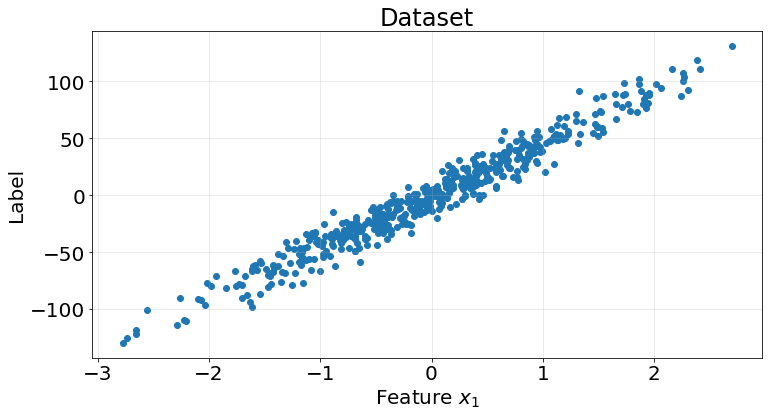

In [4]:
X, y = make_regression(n_samples=500, n_features=1, n_informative=1, n_targets=1, noise=10, random_state=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.scatter(X, y)
ax.grid(True, alpha=.3)
ax.set_title("Dataset", fontsize=24)
ax.set_xlabel("Feature $x_{1}$", fontsize=20)
ax.set_ylabel("Label", fontsize=20)
ax.tick_params(labelsize=20)

In [5]:
kf = KFold(n_splits=5)

r2_scores = []
for train_idx, test_idx in kf.split(X):
    model = OLSLinearRegression()

    X_train = X[train_idx]
    y_train = y[train_idx]

    X_test = X[test_idx]
    y_test = y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = r2_score(y_true=y_test, y_pred=y_pred)
    r2_scores.append(score)

Pretty good results from this naive model on the synthetic dataset

In [6]:
np.array(r2_scores).mean()

0.9534244993205533

### 2.2. Gradient descent example

We perform the very same thing using the gradient descent solution

In [7]:
kf = KFold(n_splits=5)

r2_scores = []
for train_idx, test_idx in kf.split(X):
    model = GDLinearRegression(batch_size=32, n_epochs=10_000)

    X_train = X[train_idx]
    y_train = y[train_idx]

    X_test = X[test_idx]
    y_test = y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = r2_score(y_true=y_test, y_pred=y_pred)
    r2_scores.append(score)

It takes a bit longer due to the iterative nature of the algorithm but we achieve the same results.

In [8]:
np.array(r2_scores).mean()

0.9534223387121132

If we take the last model and plot its loss we observe a clear decrease the more batches we perform:

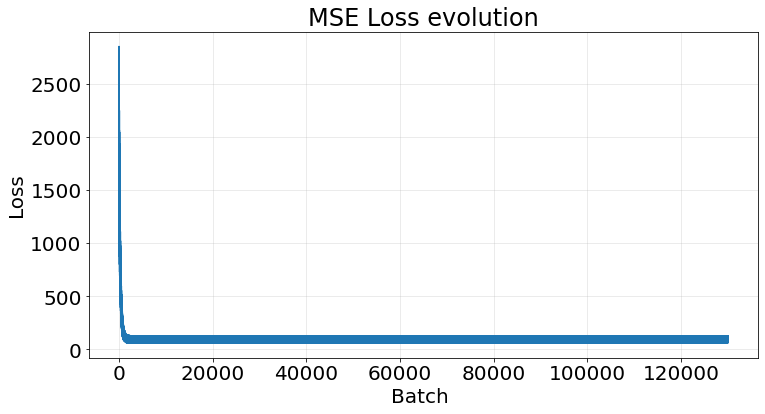

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(model.loss)
ax.grid(True, alpha=.3)

ax.set_title("MSE Loss evolution", fontsize=24)
ax.set_xlabel("Batch ", fontsize=20)
ax.set_ylabel("Loss", fontsize=20)
ax.tick_params(labelsize=20)

## 3. Strengths and Weaknesses

A summary of strenghts and weaknesses of this model.

### Pros

* Simple and escalable.
* Interpretable.
* Efficient for large datasets with linear relationships.

### Cons

* Assumes linear relationships.
* Sensitive to outliers.
* Limited at handling complex relationships